# Annotate PPI scores with ClinVar annotations

In [1]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
sqy2h_outputs_dir = "../3_outputs/sqY2H"
metadata_outputs_dir = "../../../1_allele_collection/3_outputs"
integrative_inputs = "../../../3_integrated_assay_results/1_inputs"

In [3]:
# process metadata
metadata = pl.DataFrame(pd.read_csv(f"{metadata_outputs_dir}/varchamp_consolidated_alleles_clinvar_gnomad.tsv", sep="\t"))
mut_cols = ["mutation_id_rc4", "mutation_id_cegs2", "mutation_id_edgotyping3"]
id_vars = [col for col in metadata.columns if col not in mut_cols]
metadata = metadata.unpivot(index=id_vars, 
                            on=mut_cols,
                            variable_name="mutation_collection",
                            value_name="mut_id")

priority_col = ["orf_id", "mut_id", "symbol", "aa_change", "ensembl_gene_id", "clinvar_clnsig_clean", "gnomad_af", "StarStatus"]
metadata = metadata.select(priority_col).filter(~pl.col("mut_id").is_null()).with_columns(
    pl.col("mut_id").cast(pl.Int64).alias("mut_id"),
    pl.col("orf_id").cast(pl.Int64).alias("orf_id")
)

In [4]:
# merge scores with metadata
scores = pl.read_csv(f"{sqy2h_outputs_dir}/5_variant_perturbation_scores.csv").with_columns(
    pl.col("db_orf_id").cast(pl.Int64).alias("orf_id"),
    pl.col("db_mut_id").cast(pl.Int64).alias("mut_id"),
).drop(["db_orf_id", "db_mut_id"])

scores = scores.join(metadata, on=["orf_id", "mut_id"])
scores.write_csv(f"{sqy2h_outputs_dir}/6_variant_perturbation_scores_annotated.csv")
scores.write_csv(f"{integrative_inputs}/ppi_scores.csv")
scores = scores.filter(pl.col("clinvar_clnsig_clean") != "5_Others")

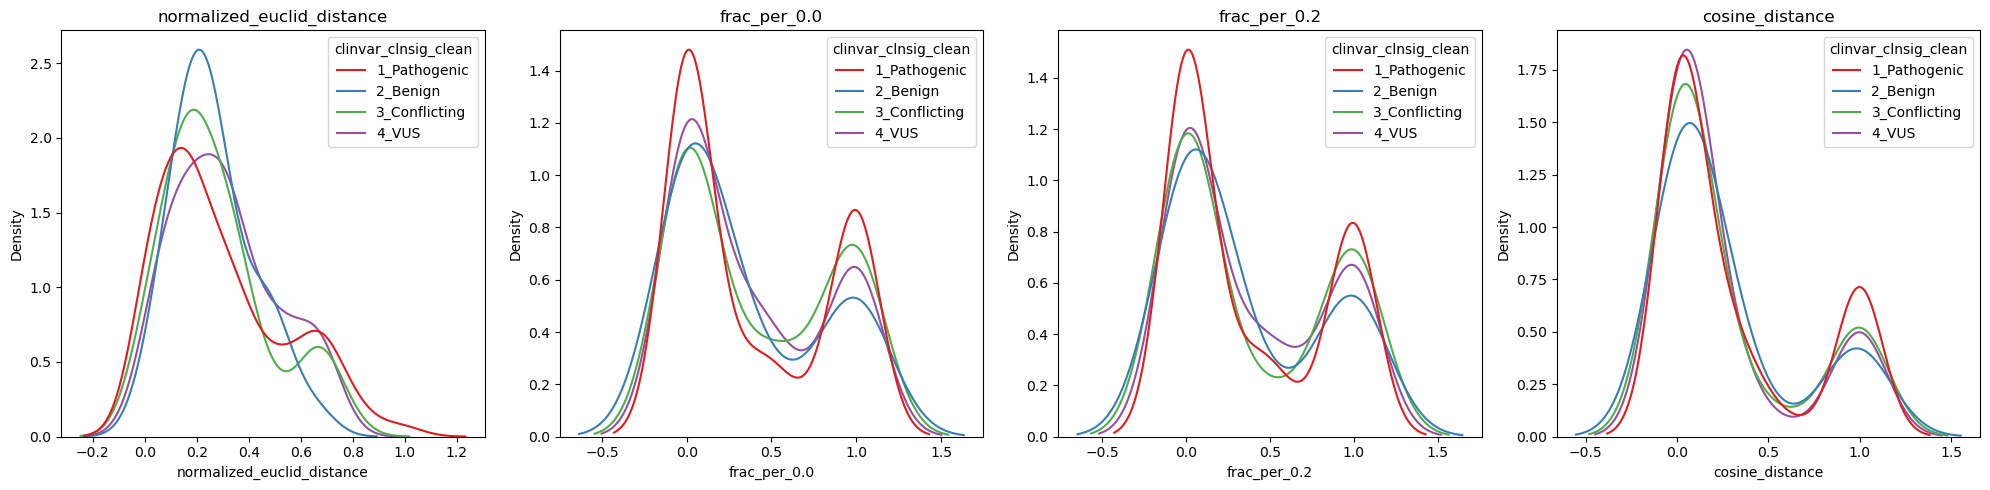

In [5]:
# Define variables to plot
variables = ["normalized_euclid_distance", "frac_per_0.0", "frac_per_0.2", "cosine_distance"]
num_vars = len(variables)

# Create a FacetGrid for multiple subplots
fig, axes = plt.subplots(1, num_vars, figsize=(num_vars*5, 5)) ## , sharey=True
hue_order = sorted(scores["clinvar_clnsig_clean"].drop_nulls().unique().to_list())
# Loop through variables and create subplots
for ax, var in zip(axes, variables):
    sns.kdeplot(
        data=scores,
        x=var,
        hue="clinvar_clnsig_clean",
        hue_order=hue_order,
        ax=ax,
        palette="Set1",
        common_norm=False
    )
    ax.set_title(var)
plt.tight_layout()
plt.show()

(527, 40)
(204, 40)


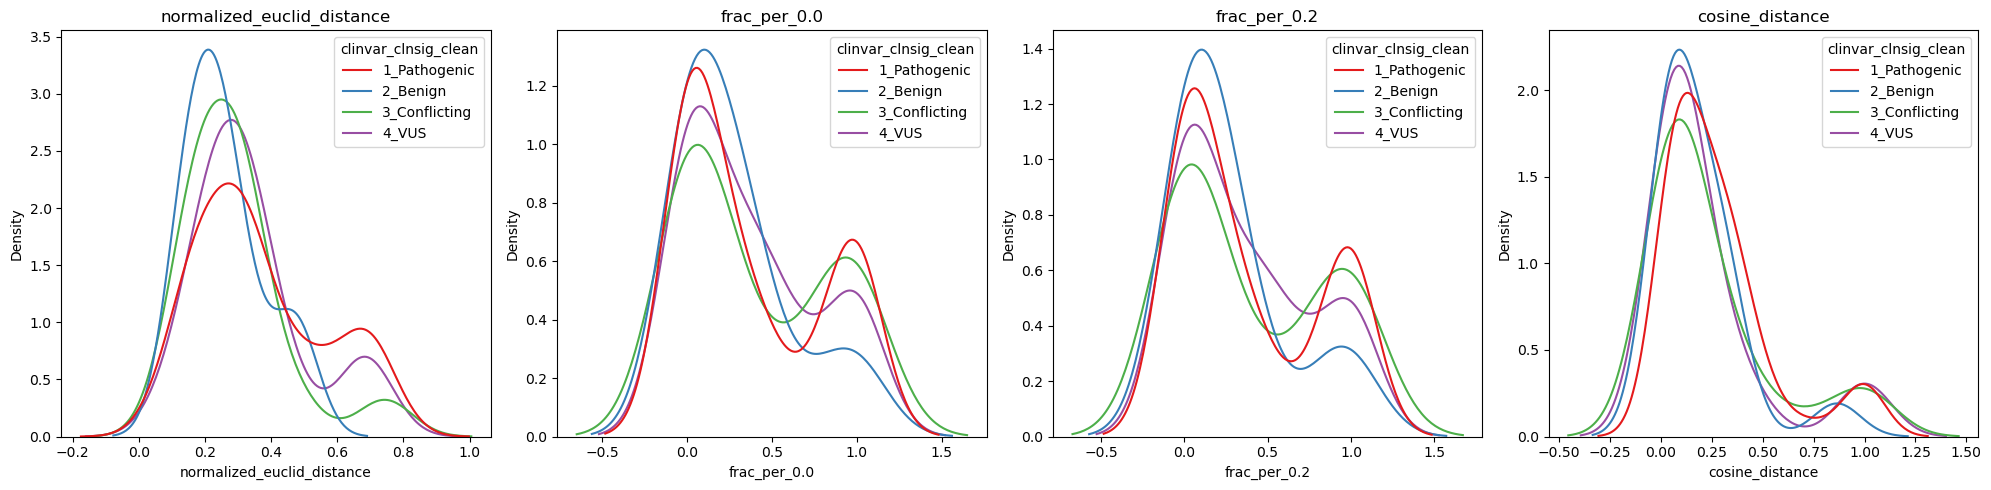

In [6]:
print(scores.shape)
scores_filt = scores.filter(pl.col("num_edges") >= 5)
print(scores_filt.shape)

# Define variables to plot
num_vars = len(variables)

# Create a FacetGrid for multiple subplots
fig, axes = plt.subplots(1, num_vars, figsize=(num_vars*5, 5)) ## , sharey=True
hue_order = sorted(scores_filt["clinvar_clnsig_clean"].drop_nulls().unique().to_list())
# Loop through variables and create subplots
for ax, var in zip(axes, variables):
    sns.kdeplot(
        data=scores_filt,
        x=var,
        hue="clinvar_clnsig_clean",
        hue_order=hue_order,
        ax=ax,
        palette="Set1",
        common_norm=False
    )
    ax.set_title(var)
plt.tight_layout()
plt.show()

(527, 40)
(94, 40)


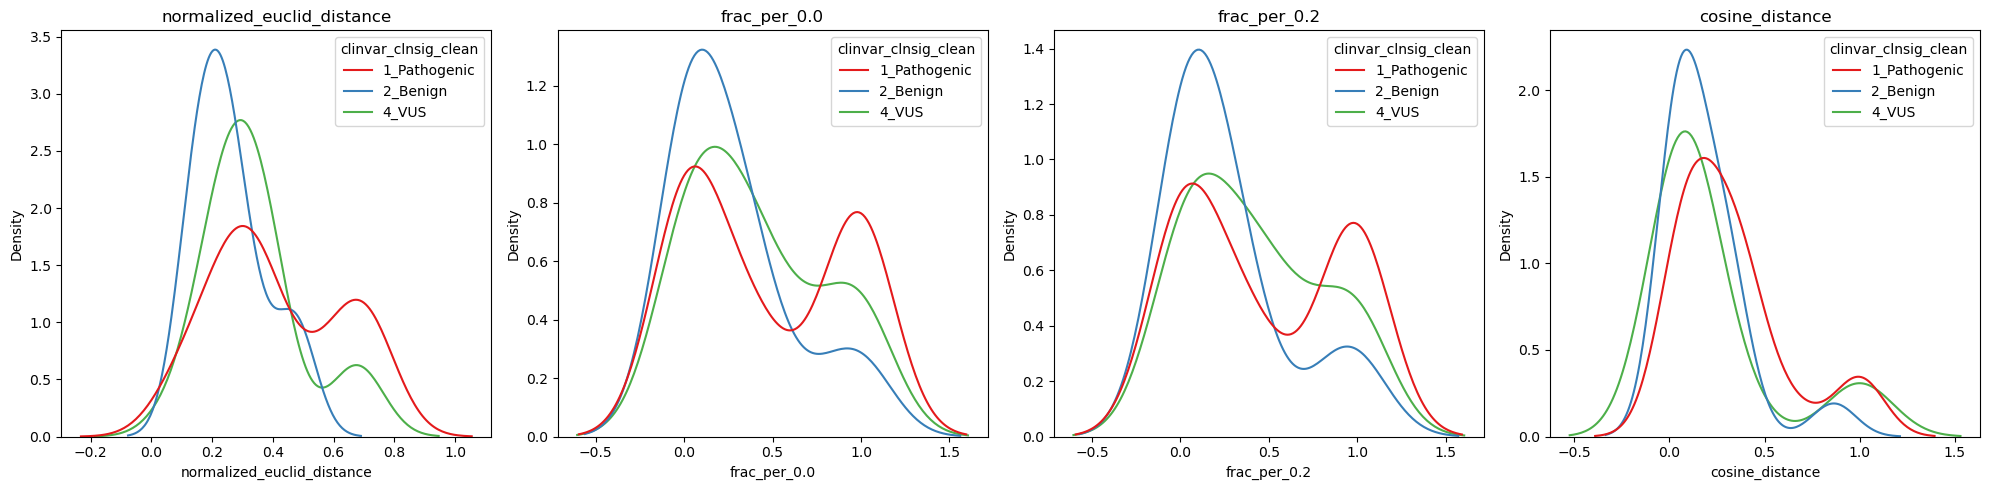

In [7]:
print(scores.shape)
scores_filt = scores.filter(pl.col("num_edges") >= 5).filter(pl.col("StarStatus") >= 2)
print(scores_filt.shape)

# Define variables to plot
num_vars = len(variables)

# Create a FacetGrid for multiple subplots
fig, axes = plt.subplots(1, num_vars, figsize=(num_vars*5, 5)) ## , sharey=True
hue_order = sorted(scores_filt["clinvar_clnsig_clean"].drop_nulls().unique().to_list())
# Loop through variables and create subplots
for ax, var in zip(axes, variables):
    sns.kdeplot(
        data=scores_filt,
        x=var,
        hue="clinvar_clnsig_clean",
        hue_order=hue_order,
        ax=ax,
        palette="Set1",
        common_norm=False
    )
    ax.set_title(var)
plt.tight_layout()
plt.show()

## Calculate number of conflicting/VUS that could be reclassified

The normalized scores show good separation. How many alleles would this enable us to putatively reclassify?

(35, 40)
(306, 40)
(98, 40)
(88, 40)


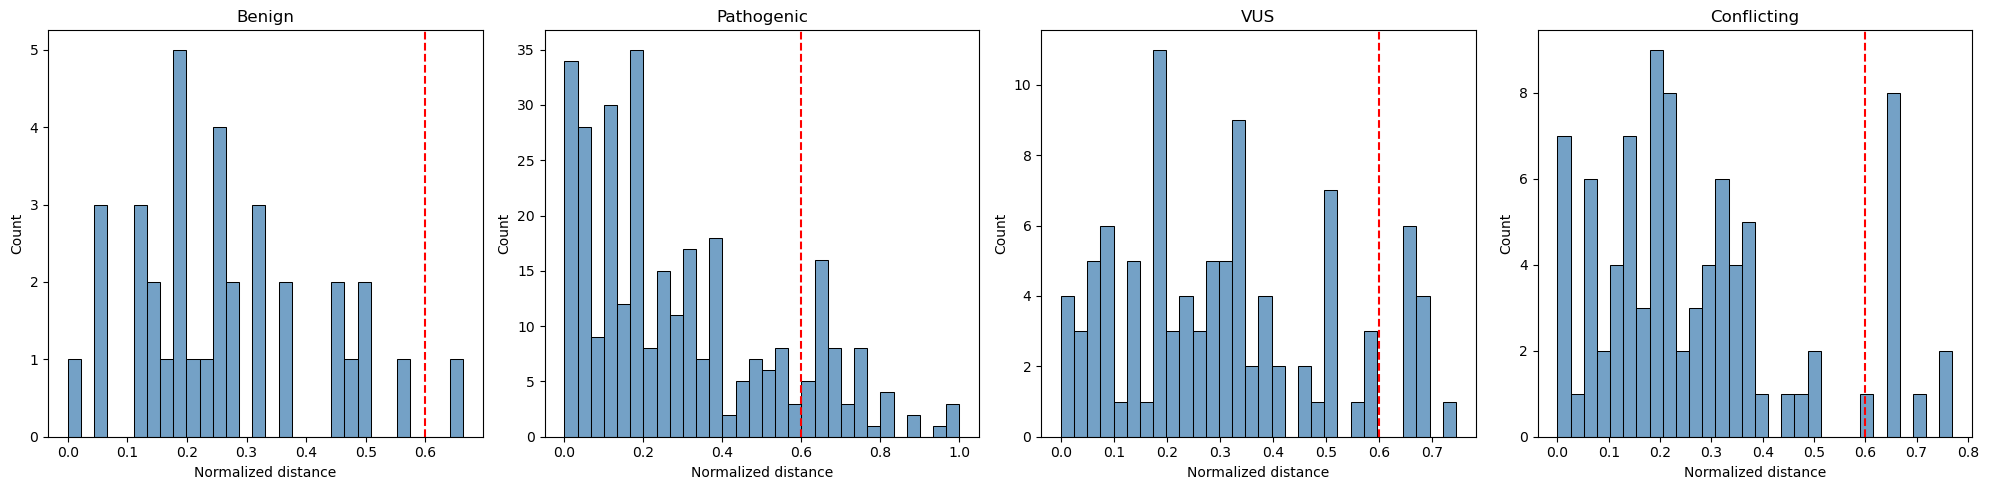

With this threshold, we classify 11 VUS and 11 conflicting alleles as pathogenic at ~5% error rate.


In [8]:
num_edge_filter = 1

benign_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "2_Benign").filter(pl.col("num_edges") >= num_edge_filter)
print(benign_scores.shape)

path_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "1_Pathogenic").filter(pl.col("num_edges") >= num_edge_filter)
print(path_scores.shape)

vus_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "4_VUS").filter(pl.col("num_edges") >= num_edge_filter)
print(vus_scores.shape)

conf_scores = scores.filter(pl.col("clinvar_clnsig_clean") == "3_Conflicting").filter(pl.col("num_edges") >= num_edge_filter)
print(conf_scores.shape)

# Setup subplots
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
plot_data = [
    ("Benign", benign_scores, axs[0]),
    ("Pathogenic", path_scores, axs[1]),
    ("VUS", vus_scores, axs[2]),
    ("Conflicting", conf_scores, axs[3]),
]

# Plot each group
for title, data, ax in plot_data:
    sns.histplot(data=data, x="normalized_euclid_distance", bins=30, color="steelblue", kde=False, ax=ax)
    ax.axvline(0.6, color="red", linestyle="--", linewidth=1.5)
    ax.set_title(title)
    ax.set_xlabel("Normalized distance")
    ax.set_ylabel("Count")
    ax.grid(False)

plt.tight_layout()
plt.show()

print(f"With this threshold, we classify {vus_scores.filter(pl.col('normalized_euclid_distance') > 0.6).shape[0]} VUS and {conf_scores.filter(pl.col('normalized_euclid_distance') > 0.6).shape[0]} conflicting alleles as pathogenic at ~5% error rate.")

# This is ~13.4% of VUS/conflicting

## Consider gnomAD frequency

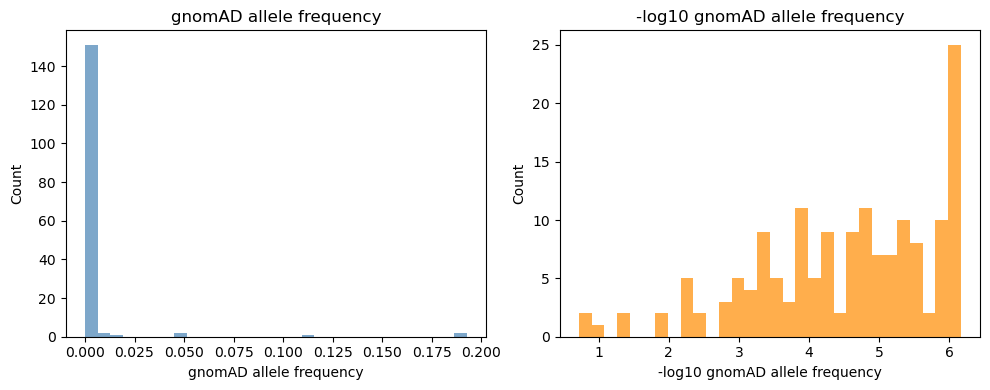

In [9]:
x = scores['gnomad_af']
x = x.filter(x > 0)

y = -np.log10(x.to_numpy())

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].hist(x, bins=30, color='steelblue', alpha=0.7)
axs[0].set_title("gnomAD allele frequency")
axs[0].set_xlabel("gnomAD allele frequency")
axs[0].set_ylabel("Count")

axs[1].hist(y, bins=30, color='darkorange', alpha=0.7)
axs[1].set_title("-log10 gnomAD allele frequency")
axs[1].set_xlabel("-log10 gnomAD allele frequency")
axs[1].set_ylabel("Count")

plt.tight_layout()
plt.show()

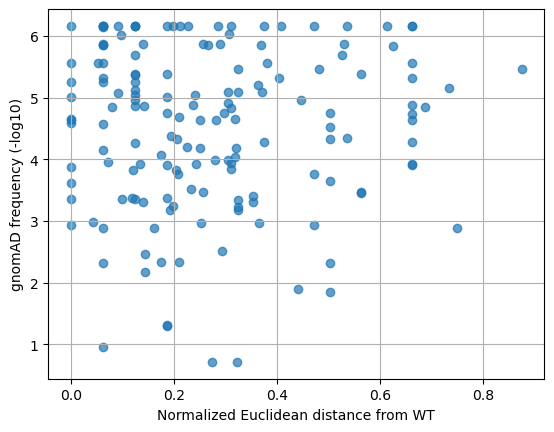

In [10]:
scores = scores.with_columns(
    (-1*pl.col("gnomad_af").log10()).alias("nlog10_gnomad_af")
)

plt.scatter(scores['normalized_euclid_distance'], scores['nlog10_gnomad_af'], alpha=0.7)
plt.ylabel('gnomAD frequency (-log10)')
plt.xlabel('Normalized Euclidean distance from WT')
plt.grid(True)
plt.show()

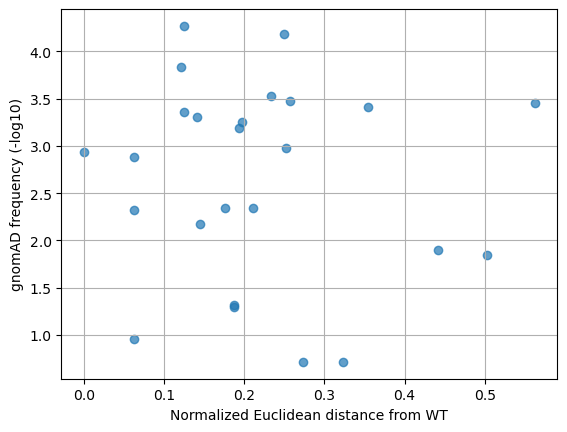

In [11]:
scores_benign = scores.filter(pl.col("clinvar_clnsig_clean") == "2_Benign")

plt.scatter(scores_benign['normalized_euclid_distance'], scores_benign['nlog10_gnomad_af'], alpha=0.7)
plt.ylabel('gnomAD frequency (-log10)')
plt.xlabel('Normalized Euclidean distance from WT')
plt.grid(True)
plt.show()